# Dependencies

In [1]:
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Exploratory
from pandas_profiling import ProfileReport

# Pandas Config
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Seaborn Theme 
sns.set_theme(style = "white")

# Useful Functions

In [2]:
def get_summary(df: pd.DataFrame, pred: bool = False) -> pd.DataFrame: 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()]).squeeze(axis = 0)
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew(numeric_only = True)
    kurtosis = df.kurtosis(numeric_only = True)
    
    print('Data shape:', df.shape)
    
    if ~pred:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        df_summary = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort = True)

    else:
        corr = df.corr()[pred]
        df_summary = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort = True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    df_summary.columns = cols
    
    return df_summary

def plot_missing_values(df: pd.DataFrame):
    # Missing Values Percentage
    missing_values = df.isna().mean().sort_values(ascending = False)
    missing_values = missing_values[missing_values > 0]*100

    # Plot Missing Values
    plt.figure(figsize = (10, 7)) 
    missing_values.plot.bar(fontsize = 15, color = "c", alpha = 0.9)
    plt.title("Porcentaje de Valores Faltantes", fontsize = 20)
    plt.legend()
    plt.show()
    
def tidy_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    # Get Numpy Array
    array = df.values.copy()
    n_variables = array.shape[0]
    variables_names = df.columns

    # Get Indices of Lower Triangule Matrix
    iu2 = np.triu_indices(n_variables)

    # Drop Upper Triangule Matrix
    array[iu2] = 9999
    corr_mat = pd.DataFrame(array, index = variables_names, columns = variables_names)
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.query("r != 9999")
    
    # Abs of Correlation
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return corr_mat.reset_index(drop = True)

# Esta función verifica si las listas con los tipos de datos coinciden con los nombres de las columnas
# Además verifica si no se repitieron las columnas en dos tipos o más de datos
def very_amount_columns(list_columns:list, list_lists_types: list) -> bool:
    # Check if the amount of columns is the same
    amount_type = 0
    list_types = []
    for list_type in list_lists_types:
        amount_type += len(list_type)
        list_types += list_type
    same_amount_columns = len(list_columns) == amount_type

    # Check if the names of columns is the same
    same_name_columns = set(list_types) == set(list_columns)
    
    if same_amount_columns & same_name_columns:
        return True
    else:
        if not same_amount_columns:
            print("La cantidad de columnas no coincide")
        if not same_name_columns:
            print("Los nombres de las columnas no coincide")
        return False

# Global Variables

In [3]:
RANDOM_STATE = 12354

# Read Data

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

Source: [Kaggle Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

**Churn rate:** in its broadest sense, is a measure of the number of individuals or items moving out of a collective group over a specific period.
Source: [Churn rate-wikipedia](https://en.wikipedia.org/wiki/Churn_rate)

In [4]:
# Paths
root = os.getcwd()
data_folder_path = os.path.join("data")

data_file_path = os.path.join(data_folder_path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
# Read Data
data = pd.read_csv(data_file_path)

In [6]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Quick EDA

In [7]:
get_summary(data).sort_index()

Data shape: (7043, 21)


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
Churn,object,7043,2,0,0.0,"[No, Yes]",NaN,NaN
Contract,object,7043,3,0,0.0,"[Month-to-month, One year, Two year]",NaN,NaN
Dependents,object,7043,2,0,0.0,"[No, Yes]",NaN,NaN
DeviceProtection,object,7043,3,0,0.0,"[No, Yes, No internet service]",NaN,NaN
InternetService,object,7043,3,0,0.0,"[DSL, Fiber optic, No]",NaN,NaN
MonthlyCharges,float64,7043,1585,0,0.0,"[29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1, 29.75, 104.8, 56.15, 49.95, 18.95, 100.35, 103.7,...",-0.220524,-1.257260
MultipleLines,object,7043,3,0,0.0,"[No phone service, No, Yes]",NaN,NaN
OnlineBackup,object,7043,3,0,0.0,"[Yes, No, No internet service]",NaN,NaN
OnlineSecurity,object,7043,3,0,0.0,"[No, Yes, No internet service]",NaN,NaN
PaperlessBilling,object,7043,2,0,0.0,"[Yes, No]",NaN,NaN


# Pandas Profiling Report

In [8]:
profile = ProfileReport(data, title = "Pandas Profiling Report")

In [33]:
profile.to_file("stroke_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

## Data Types

In [10]:
cuantitative_columns = ['TotalCharges',
                       'tenure',
                       'MonthlyCharges']

cualitative_columns = ['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen']

date_columns = []

code_columns = ['customerID']

text_columns = []

columns_types_list = [cuantitative_columns, cualitative_columns, date_columns, code_columns, text_columns]

In [11]:
# To Avoid  Error Prone While writing Column Types
very_amount_columns(data.columns.tolist(), columns_types_list)

True

In [12]:
columns_types_list_num = [len(c) for c in columns_types_list]
columns_types_list_names = ["Cuantitativos", "Cualitativos", "Fechas", "Códigos", "Textos"]

In [13]:
# Tipos de Datos
tipos_datos_df = pd.DataFrame({"Tipos de Datos": columns_types_list_names,
                               "Número de Columnas": columns_types_list_num})
tipos_datos_df.sort_values("Número de Columnas", ascending = False)

,Tipos de Datos,Número de Columnas
1,Cualitativos,17
0,Cuantitativos,3
3,Códigos,1
2,Fechas,0
4,Textos,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
data[cualitative_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            7043 non-null   object
 1   Partner           7043 non-null   object
 2   Dependents        7043 non-null   object
 3   PhoneService      7043 non-null   object
 4   MultipleLines     7043 non-null   object
 5   InternetService   7043 non-null   object
 6   OnlineSecurity    7043 non-null   object
 7   OnlineBackup      7043 non-null   object
 8   DeviceProtection  7043 non-null   object
 9   TechSupport       7043 non-null   object
 10  StreamingTV       7043 non-null   object
 11  StreamingMovies   7043 non-null   object
 12  Contract          7043 non-null   object
 13  PaperlessBilling  7043 non-null   object
 14  PaymentMethod     7043 non-null   object
 15  Churn             7043 non-null   object
 16  SeniorCitizen     7043 non-null   int64 
dtypes: int64(1), o

In [16]:
data[cuantitative_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TotalCharges    7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   MonthlyCharges  7043 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.2+ KB


In [17]:
data["TotalCharges"] = data["TotalCharges"].replace(" ", "0").astype(float)

## Data Dimention

In [18]:
data.shape

(7043, 21)

## Duplicated Rows

In [19]:
data.duplicated().sum()

0

## Distribution of Cuantitative Variables

In [20]:
for col in cuantitative_columns:
    n_zero_values = (data[col] == 0).sum()
    n_negative_values = (data[col] < 0).sum()
    if n_zero_values > 0:
        print(f"The variable {col} has {n_zero_values} cero values.")
    if n_negative_values > 0:
        print(f"The variable {col} has {n_negative_values} cero values.")

The variable TotalCharges has 11 cero values.
The variable tenure has 11 cero values.


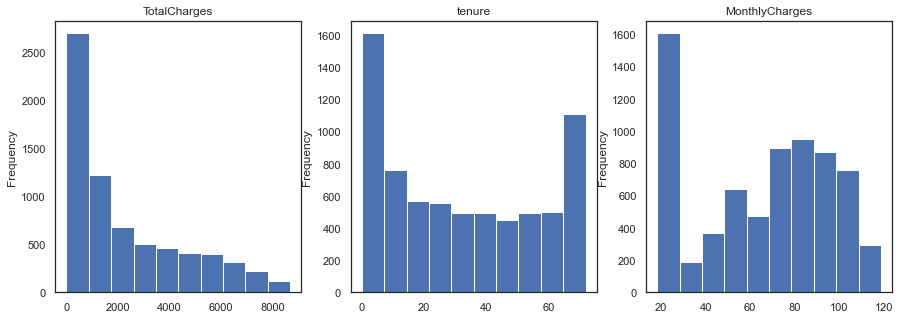

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes = axes.flat
for i, col in enumerate(cuantitative_columns):
    data[col].plot.hist(title = col, ax = axes[i])
plt.show()

## Distribution of Cuantitative Variables

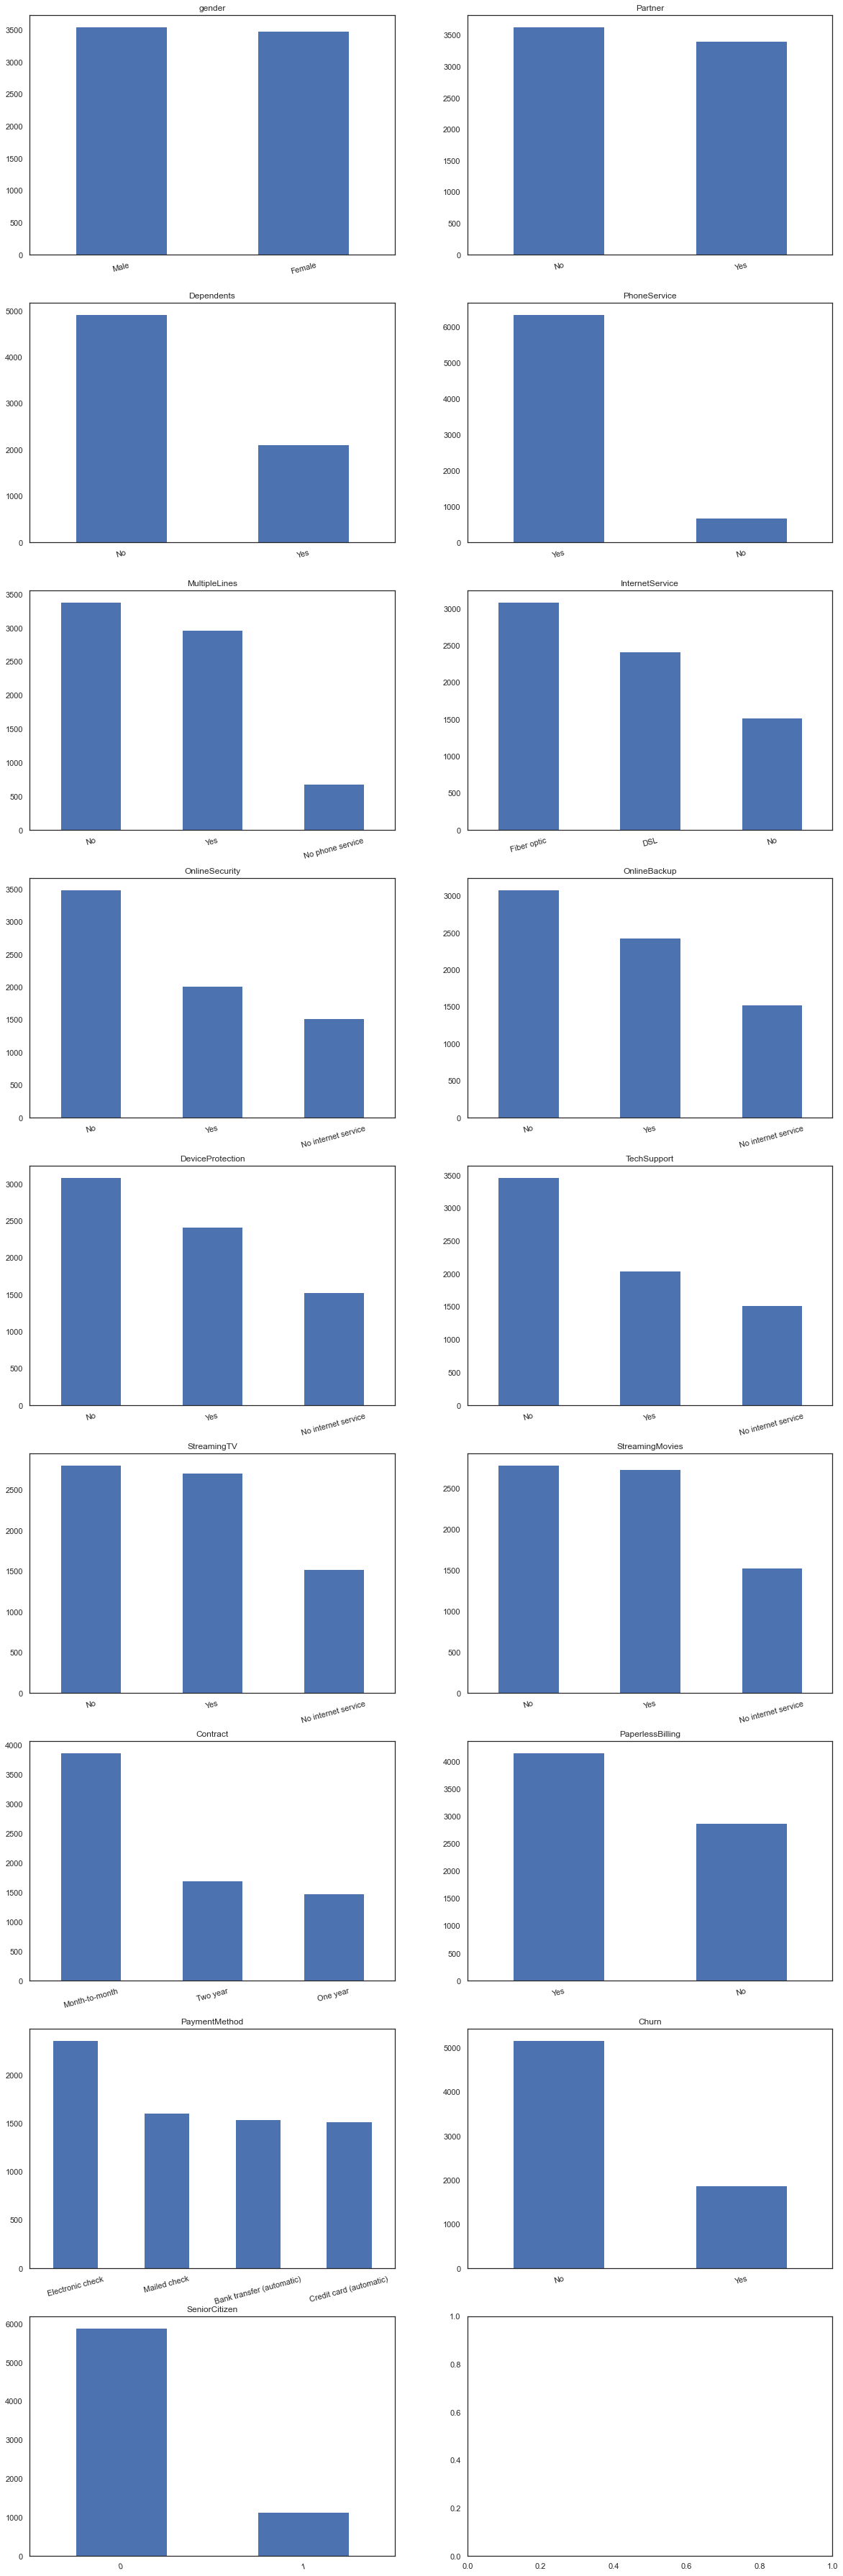

In [22]:
fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (20, 65))
axes = axes.flat
for i, col in enumerate(cualitative_columns):
    data[col].value_counts().plot.bar(title = col, ax = axes[i], rot = 15)
plt.show()

## Missing Values

In [23]:
# Columns with Missing Values
(data.isna().sum() > 0).sum()

0

In [24]:
#plot_missing_values(data)

## Outliers

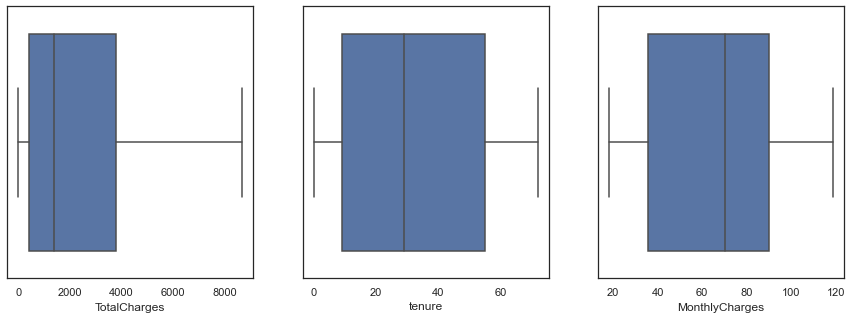

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes = axes.flat
for i, col in enumerate(cuantitative_columns):
    sns.boxplot(x = data[col], ax = axes[i])

## Correlation

In [26]:
corr_matrix = data[cuantitative_columns].corr(method='pearson')

In [27]:
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
0,tenure,TotalCharges,0.826178,0.826178
1,MonthlyCharges,TotalCharges,0.651174,0.651174
2,MonthlyCharges,tenure,0.247900,0.247900


In [28]:
tidy_corr_mat = tidy_corr_matrix(corr_matrix).head(10)
top_10_corr = set(tidy_corr_mat.variable_1.tolist() + tidy_corr_mat.variable_2.tolist())
corr_matrix_top10 = data[top_10_corr].corr(method='pearson')

<AxesSubplot:>

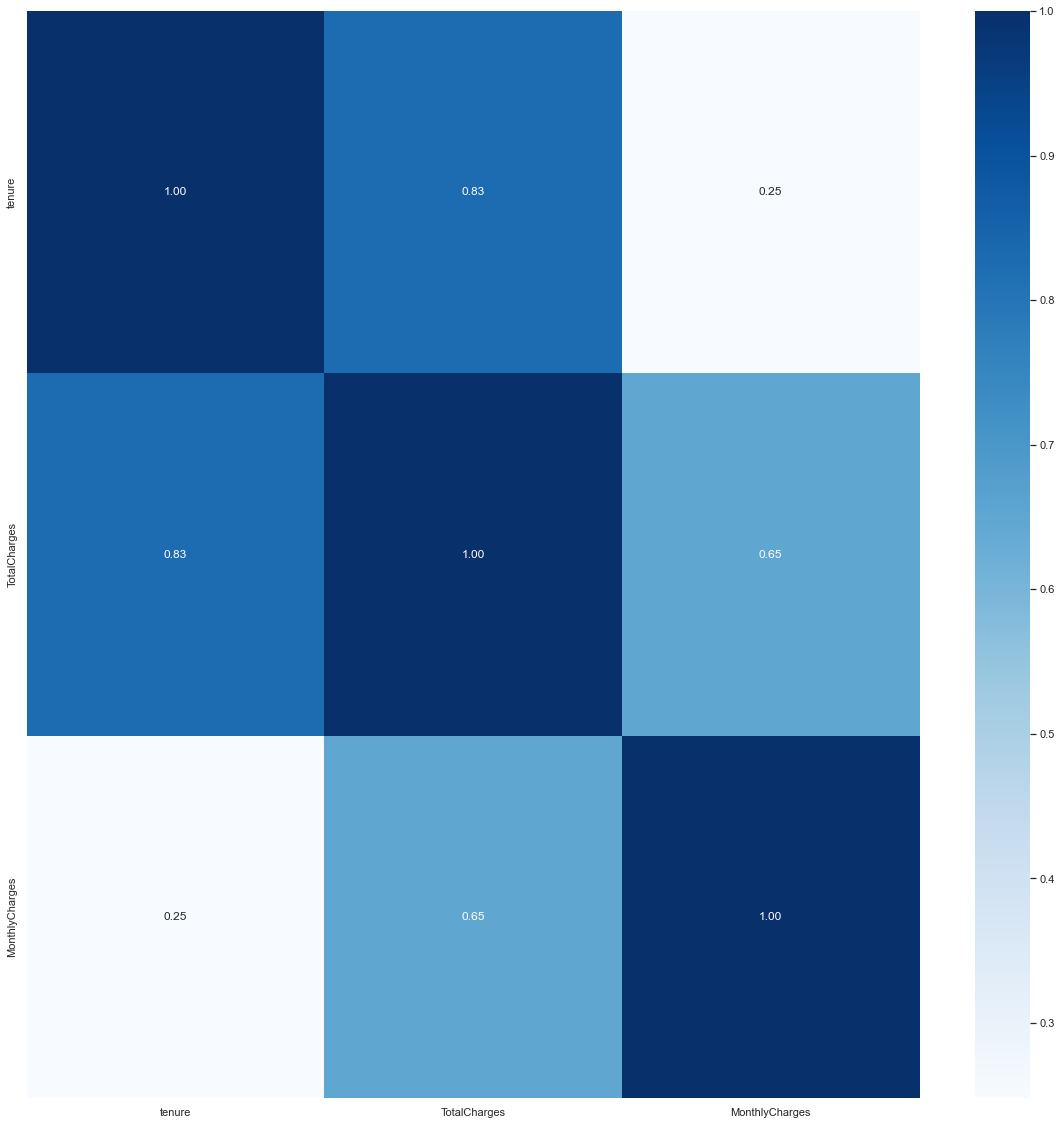

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20, 20))
sns.heatmap(corr_matrix_top10, fmt = '.2f', cmap = "Blues", annot = True)

## Churn Boxplots

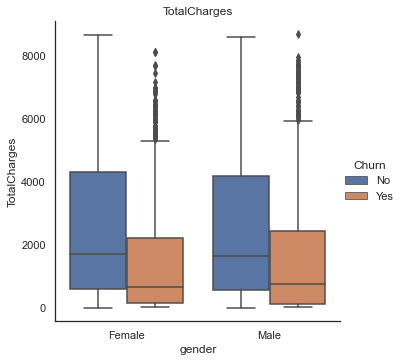

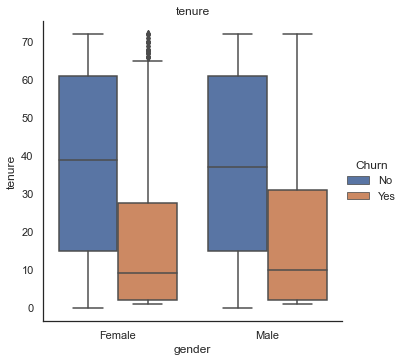

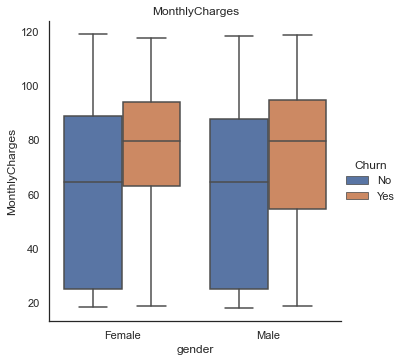

In [30]:
for y_value in cuantitative_columns:
    sns.catplot(x = "gender", y = y_value, hue = "Churn", kind = "box", data = data)
    plt.title(y_value)

In [31]:
TotalCharges   ->  to  float

SyntaxError: invalid syntax (Temp/ipykernel_14992/2954642747.py, line 1)